In [ ]:
import vk_api
import time
import pandas as pd
import sqlite3
from datetime import datetime
from config import token 

# Создаем подключение
session = vk_api.VkApi(token)
conn = sqlite3.connect('vk_posts.db')

In [ ]:
USER_ID = 'erglerik'    # screen_name или owner_id

#ссылка = "https://vk.com/erglerik"

MAX_POSTS = 300
BATCH_SIZE = 50


vk_session = vk_api.VkApi(token=token)
vk = vk_session.get_api()

all_posts = []
offset = 0

In [70]:
while len(all_posts) < MAX_POSTS:
    count = min(BATCH_SIZE, MAX_POSTS - len(all_posts))

    response = vk.wall.get(
        owner_id=USER_ID,
        count=count,
        offset=offset,
        extended=0
    )

    items = response.get('items', [])
    if not items:
        break

    all_posts.extend(items)
    offset += count

    time.sleep(0.4)  # Не перегружаем API

# --- Обработка данных ---
posts_data = []

for i, post in enumerate(all_posts, 1):
    post_datetime = datetime.fromtimestamp(post['date'])
    likes = post.get('likes', {}).get('count', 0)

    posts_data.append({
        'Номер поста': i,
        'Дата': post_datetime.date(),
        'Время': post_datetime.time(),
        'Лайки': likes,
    })

# Создаем DataFrame
df = pd.DataFrame(posts_data)

df = df.drop(df.index[0])



In [71]:
df.columns = ['PostNumber', 'Date', 'Time', 'Likes']
df.to_sql('posts', conn, if_exists='replace', index=False)
df.head(10)

,PostNumber,Date,Time,Likes
1,2,2025-07-18,02:14:18,79
2,3,2025-06-27,19:15:28,57
3,4,2025-06-27,19:14:45,48
4,5,2025-04-26,03:01:58,106
5,6,2024-11-01,23:24:29,83
6,7,2024-10-19,02:25:31,60
7,8,2024-10-19,02:24:28,73
8,9,2024-10-19,02:23:50,105
9,10,2024-09-11,03:31:46,111
10,11,2024-08-25,01:06:09,61


In [ ]:
query_1 = """
WITH posts_with_weekday AS (
    SELECT
        *,
        CASE strftime('%w', Date)
            WHEN '0' THEN 'Sunday'
            WHEN '1' THEN 'Monday'
            WHEN '2' THEN 'Tuesday'
            WHEN '3' THEN 'Wednesday'
            WHEN '4' THEN 'Thursday'
            WHEN '5' THEN 'Friday'
            WHEN '6' THEN 'Saturday'
        END AS weekday
    FROM posts
),
ranked_posts AS (
    SELECT
        weekday,
        Likes,
        ROW_NUMBER() OVER (PARTITION BY weekday ORDER BY Likes) AS rn,
        COUNT(*) OVER (PARTITION BY weekday) AS cnt
    FROM posts_with_weekday
),
median_likes AS (
    SELECT
        weekday,
        AVG(Likes) AS median_likes
    FROM ranked_posts
    WHERE rn = (cnt + 1) / 2
       OR rn = (cnt + 2) / 2
    GROUP BY weekday
)
SELECT * FROM median_likes
ORDER BY median_likes DESC;

"""

result_df_1 = pd.read_sql_query(query_1, conn)
result_df_1.head(10)



,weekday,median_likes
0,Thursday,23.0
1,Sunday,13.0
2,Monday,12.0
3,Tuesday,11.0
4,Saturday,3.0
5,Friday,2.5
6,Wednesday,1.0


In [82]:
result_df_1.to_csv('res_sql_week_days.csv')

In [73]:
query_2 = """
WITH posts_with_period AS (
    SELECT
        *,
        CASE 
            WHEN CAST(strftime('%H', Time) AS INTEGER) BETWEEN 0 AND 5 THEN 'Night'
            WHEN CAST(strftime('%H', Time) AS INTEGER) BETWEEN 6 AND 11 THEN 'Morning'
            WHEN CAST(strftime('%H', Time) AS INTEGER) BETWEEN 12 AND 17 THEN 'Afternoon'
            WHEN CAST(strftime('%H', Time) AS INTEGER) BETWEEN 18 AND 23 THEN 'Evening'
        END AS period
    FROM posts
),
ranked_posts AS (
    SELECT
        period,
        Likes,
        ROW_NUMBER() OVER (PARTITION BY period ORDER BY Likes) AS rn,
        COUNT(*) OVER (PARTITION BY period) AS cnt
    FROM posts_with_period
),
median_likes AS (
    SELECT
        period,
        ROUND(AVG(Likes), 2) AS median_likes
    FROM ranked_posts
    WHERE rn = (cnt + 1) / 2
       OR rn = (cnt + 2) / 2  -- обрабатываем и чётное, и нечётное количество постов
    GROUP BY period
)
SELECT * FROM median_likes
ORDER BY median_likes DESC;
"""

result_df_2 = pd.read_sql_query(query_2, conn)
result_df_2.head(10)


,period,median_likes
0,Night,55.0
1,Evening,11.0
2,Afternoon,5.5
3,Morning,0.0


In [83]:
result_df_2.to_csv('res_sql_day_period.csv')

In [74]:
import matplotlib.pyplot as plt

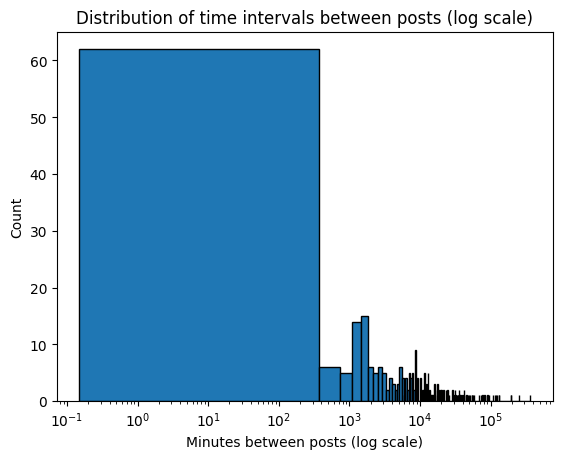

In [75]:
# 1. Создадим колонку с полным datetime
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))

# 2. Отсортируем по времени постов
df = df.sort_values('DateTime').reset_index(drop=True)

# 3. Рассчитаем разницу во времени с предыдущим постом в секундах
df['diff_seconds'] = df['DateTime'].diff().dt.total_seconds()

# 4. Переведём разницу в часы
df['diff_hours'] = df['diff_seconds'] / 3600

# 5. Уберём NaN в первой строке (у первого поста нет предыдущего)
diff_hours = df['diff_hours'].dropna()

# Переводим часы в минуты
diff_minutes = diff_hours * 60

# Убираем нули и отрицательные значения (если есть)
diff_minutes_positive = diff_minutes[diff_minutes > 0]

plt.hist(diff_minutes_positive, bins=1000, edgecolor='black')
plt.xscale('log')  # логарифмическая шкала по оси X
plt.xlabel('Minutes between posts (log scale)')
plt.ylabel('Count')
plt.title('Distribution of time intervals between posts (log scale)')
plt.show()

In [77]:
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))

# Сортируем по времени
df = df.sort_values('DateTime').reset_index(drop=True)

# Считаем разницу во времени между постами в минутах
df['diff_minutes'] = df['DateTime'].diff().dt.total_seconds() / 60

# Удаляем первую строку с NaN
df = df.dropna(subset=['diff_minutes'])

# Разбиваем на 6 квантильных бинов с равным количеством постов
df['interval_bin'] = pd.qcut(df['diff_minutes'], q=6, duplicates='drop')

# Считаем медиану лайков в каждом бине
bin_stats = df.groupby('interval_bin')['Likes'].agg(['count', 'median', 'mean']).reset_index()

bin_stats.head(10)

C:\Users\galki\AppData\Local\Temp\ipykernel_13660\2661919086.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby('interval_bin')['Likes'].agg(['count', 'median', 'mean']).reset_index()


,interval_bin,count,median,mean
0,"(0.149, 64.928]",50,4.0,17.720000
1,"(64.928, 1730.294]",49,2.0,8.632653
2,"(1730.294, 6207.933]",50,2.0,14.880000
3,"(6207.933, 11512.867]",49,8.0,22.346939
4,"(11512.867, 28726.672]",49,11.0,25.204082
5,"(28726.672, 364676.717]",50,50.5,50.320000


In [79]:
query_3 = """
WITH posts_with_datetime AS (
    SELECT
        PostNumber,
        Likes,
        datetime(Date || ' ' || Time) AS post_datetime
    FROM posts
),
posts_with_lag AS (
    SELECT
        PostNumber,
        Likes,
        post_datetime,
        LAG(post_datetime) OVER (ORDER BY post_datetime) AS prev_datetime
    FROM posts_with_datetime
),
posts_with_diff AS (
    SELECT
        PostNumber,
        Likes,
        post_datetime,
        prev_datetime,
        CAST((strftime('%s', post_datetime) - strftime('%s', prev_datetime)) / 60 AS REAL) AS diff_minutes
    FROM posts_with_lag
),
posts_binned AS (
    SELECT
        PostNumber,
        Likes,
        diff_minutes,
        CASE
            WHEN diff_minutes <= 64.928 THEN '0–65 min'
            WHEN diff_minutes <= 1730.294 THEN '65 min – 28 h'
            WHEN diff_minutes <= 6207.933 THEN '28 h – 4.3 d'
            WHEN diff_minutes <= 11512.867 THEN '4.3 d – 8 d'
            WHEN diff_minutes <= 28726.672 THEN '8 d – 20 d'
            ELSE '> 20 d'
        END AS diff_bin
    FROM posts_with_diff
    WHERE diff_minutes IS NOT NULL
),
ranked_posts AS (
    SELECT
        diff_bin,
        Likes,
        ROW_NUMBER() OVER (PARTITION BY diff_bin ORDER BY Likes) AS rn,
        COUNT(*) OVER (PARTITION BY diff_bin) AS cnt
    FROM posts_binned
)
SELECT
    diff_bin,
    ROUND(AVG(Likes), 2) AS mean_likes,
    ROUND(AVG(CASE
        WHEN rn = (cnt + 1) / 2 OR rn = (cnt + 2) / 2 THEN Likes
    END), 2) AS median_likes,
    COUNT(*) AS posts_count
FROM ranked_posts
GROUP BY diff_bin
ORDER BY
    CASE diff_bin
        WHEN '0–65 min' THEN 1
        WHEN '65 min – 28 h' THEN 2
        WHEN '28 h – 4.3 d' THEN 3
        WHEN '4.3 d – 8 d' THEN 4
        WHEN '8 d – 20 d' THEN 5
        WHEN '> 20 d' THEN 6
    END;
"""

result_df_3 = pd.read_sql_query(query_3, conn)
result_df_3.head(10)


,diff_bin,mean_likes,median_likes,posts_count
0,0–65 min,17.72,4.0,50
1,65 min – 28 h,8.48,1.5,50
2,28 h – 4.3 d,14.92,2.0,50
3,4.3 d – 8 d,22.35,8.0,49
4,8 d – 20 d,25.20,11.0,49
5,> 20 d,50.32,50.5,50


In [84]:
result_df_3.to_csv('res_sql_posts_time_interval.csv')